> Datasets: https://www.kaggle.com/datasets/utathya/electricity-consumption

## Download Dataset

In [ ]:
# install kaggle package
!pip install -q kaggle

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raynoldpanji","key":"fdfe72c4650d0603c8c50ad8ea6c433d"}'}

In [ ]:
# make directory and change permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
# download dataset, choose 'copy api command' from kaggle dataset
!kaggle datasets download -d utathya/electricity-consumption

  0% 0.00/458k [00:00<?, ?B/s]
100% 458k/458k [00:00<00:00, 69.3MB/s]


In [ ]:
!mkdir dataset
!unzip electricity-consumption.zip -d dataset
!ls dataset

Archive:  electricity-consumption.zip
  inflating: dataset/test.csv        
  inflating: dataset/train.csv       
test.csv  train.csv


## Data Preprocessing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM

In [ ]:
data_train = pd.read_csv('dataset/train.csv')
data_train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [ ]:
data_train.isnull().sum()

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

In [ ]:
data_train['datetime']

0        2013-07-01 00:00:00
1        2013-07-01 01:00:00
2        2013-07-01 02:00:00
3        2013-07-01 03:00:00
4        2013-07-01 04:00:00
                ...         
26491    2017-06-23 19:00:00
26492    2017-06-23 20:00:00
26493    2017-06-23 21:00:00
26494    2017-06-23 22:00:00
26495    2017-06-23 23:00:00
Name: datetime, Length: 26496, dtype: object

In [ ]:
data_train['datetime'] = pd.to_datetime(data_train['datetime'])
# data_test['datetime'] = pd.to_datetime(data_test['datetime'])

In [ ]:
time = np.array(data_train['datetime'].values)
series = np.array(data_train['temperature'].values)
 
time_split_len = int(len(series) * 0.8)
X_train = series[:time_split_len]
X_test = series[time_split_len:]
y_train = time[:time_split_len]
y_test = time[time_split_len:]

print(f'Total Data Train : {X_train.shape[0]}')
print(f'Total Data Validation : {X_test.shape[0]}')

Total Data Train : 21196
Total Data Validation : 5300


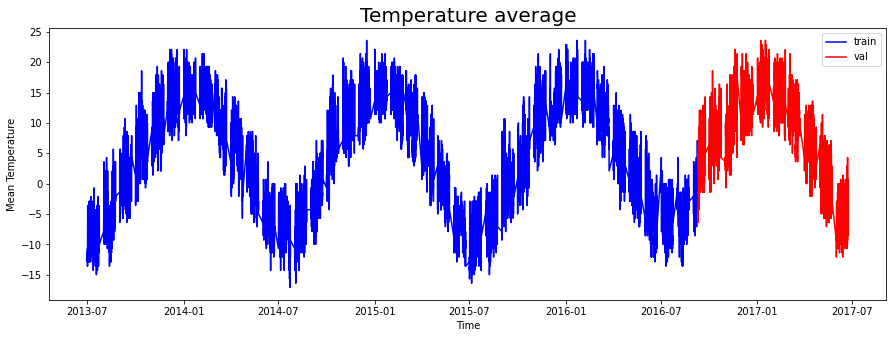

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_train, X_train, color='blue', label='train')
plt.plot(y_test, X_test, color='red', label='val')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.legend()

plt.title('Temperature average', fontsize=20);

In [ ]:
# ## reshape matrix
# from sklearn.preprocessing import MinMaxScaler

# train_xr = X_train.reshape(-1,1)
# test_xr = X_test.reshape(-1,1)

# scaler = MinMaxScaler()
# train_scaler = scaler.fit_transform(train_xr)
# test_scaler = scaler.fit_transform(test_xr)

# print(f'Total Data Train : {train_scaler.shape[0]}')
# print(f'Total Data Validation : {test_scaler.shape[0]}')

Total Data Train : 21196
Total Data Validation : 5300


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [ ]:
# Mencari nilai MAE dari model < 10% skala data
MAE = (data_train['temperature'].max() - data_train['temperature'].min()) * 0.1
print(MAE)

4.07


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < MAE and logs.get('val_mae') < MAE):
      print("\MAE dari kurang dari 10%")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=test_set, epochs=30, callbacks=[callbacks])

Epoch 1/30
212/212 [==============================] - 14s 37ms/step - loss: 7.7382 - mae: 8.2274 - val_loss: 8.8081 - val_mae: 9.3008
Epoch 2/30
212/212 [==============================] - 6s 30ms/step - loss: 7.3065 - mae: 7.7948 - val_loss: 8.1092 - val_mae: 8.6000
Epoch 3/30
212/212 [==============================] - 6s 29ms/step - loss: 6.2680 - mae: 6.7545 - val_loss: 5.7749 - val_mae: 6.2606
Epoch 4/30
212/212 [==============================] - 6s 29ms/step - loss: 4.0049 - mae: 4.4839 - val_loss: 3.2085 - val_mae: 3.6776
Epoch 5/30
212/212 [==============================] - 6s 30ms/step - loss: 3.1020 - mae: 3.5727 - val_loss: 2.9066 - val_mae: 3.3732


In [ ]:
# Plot MAE and Loss
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

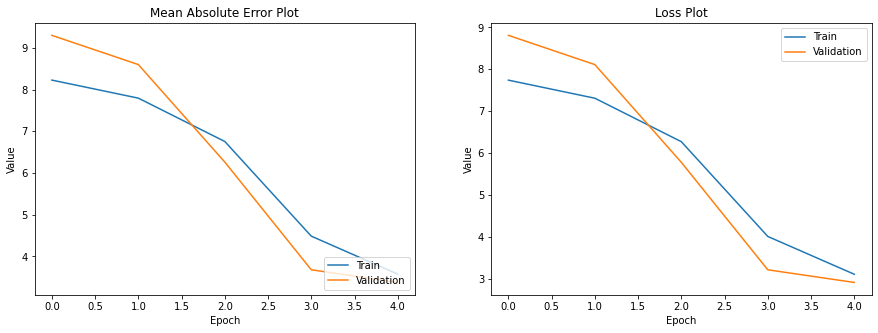

In [ ]:
figure = plt.figure(figsize = (15, 5))

figure.add_subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'], loc = 'lower right')

figure.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'], loc = 'upper right')

plt.show()

In [ ]:
# Plot Zoomed MAE and Loss
epochs_zoom = range(len(loss))[20:]

mae_zoom = history.history['mae'][20:]
val_mae_zoom = history.history['val_mae'][20:]

loss_zoom = history.history['loss'][20:]
val_loss_zoom = history.history['val_loss'][20:]


figure = plt.figure(figsize = (15, 5))

figure.add_subplot(1, 2, 1)
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, val_mae_zoom, 'b')
plt.title('Mean Absolute Error Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'], loc = 'lower right')

figure.add_subplot(1, 2, 2)
plt.plot(epochs_zoom, loss_zoom, 'r')
plt.plot(epochs_zoom, val_loss_zoom, 'b')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'], loc = 'upper right')

plt.show()

In [ ]:
train_xr = X_train.reshape(-1,1)
test_xr = X_test.reshape(-1,1)

In [ ]:
train_pred = model.predict(train_set)
test_pred = model.predict(test_set)
train_pred.shape, test_pred.shape

((21136, 1), (5240, 1))

In [ ]:
X_train.shape, X_test.shape

((21196,), (5300,))

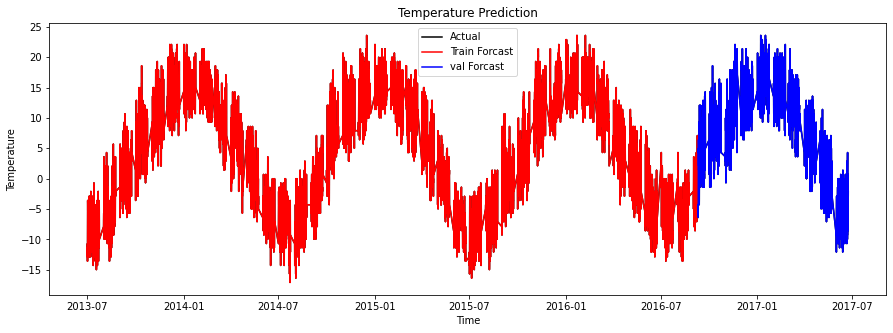

In [ ]:
X = np.append(X_train, X_test)
y = np.append(y_train, y_test)


plt.figure(figsize=(15,5))

plt.plot(y, X, color='black', label='Actual')
plt.plot(y_train, X_train, color='red', label='Train Forcast')
plt.plot(y_test, X_test, color='blue', label='val Forcast')

plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

plt.show()